# Football Betting Model

To be completed:
- Add a section with raw inputs so that the user that can input an upcoming fixture. These teams will be run through the model and will output a bet suggestion.

## Introduction:

Sports betting can be incredibly frustrating. Top of the league losing at home to bottom of the league - we've all been there. We can watch football matches all season, building up knowledge of each team and how they're playing and yet we still find it impossible to make money. 

When we look at upcoming fixtures, whether we know it or not, we are comparing the odds (and hence, winnings) with how likely we think that result will occur. We may think Manchester City are guaranteed to win at home to Huddersfield in the second game of the 2018/19 season but are odds of 1.1 on BET365 really worth the risk? A £10 bet on this would only win us £1. Maybe not. (They won 6-1 - maybe we should've!).

By evaluating bets in this way, we are looking for 'value' in a bet. Value exists when we believe an event is more likely to occur than the bookies do. The assessed probability is how likely we think an event is likely to occur and the implied probability is how likely the bookies think that outcome will occur, given their odds. Therefore, if our assessed probability of an outcome is higher than the implied probability, that outcome represents a value betting opportunity.

The implied probability (IP) can be calculated from the bookies odds using the following formula:

$$IP =	\frac{1}{(Decimal Odds)}$$

For example, let's look at the north London derby between Arsenal and Tottenham at the Emirates during the 2017/18 season. The decimal odds given for this match by BET365 were:
 - Arsenal   -> (**2.5**)
 - Draw      -> (**3.6**)
 - Tottenham -> (**2.89**)
 
The odds of Arsenal winning at 2.5 can be converted into a percentage using the formula above so that we get 40% (1/2.5). Converting the remaining odds into percentages we get:
 - Arsenal   -> **40%**
 - Draw      -> **28%**
 - Tottenham -> **35%**

(You may notice that these values add up to a greater than 100% chance. This is the cut that the bookies take to guarantee themselves profit. We will discuss this more later.)

To reiterate, 'value' bets exists when we believe an event is more likely to occur than the bookies do. In the north London derby, we may believe that the probability of Arsenal winning is 50% (assessed probability) compared to the bookies implied probability of 40%. Consequently, we would place a bet on Arsenal winning as this bet represents value for us. The final score turned out to be 2-0 to Arsenal. We WON! Easy, right?

Unfortunately, it's not always that easy. As much as we try, our predictions are almost always affected by some kind of bias. We're more likely believe our favourite teams are going to win. Recent results are more likely to over influence our decisions. By constructing a model that suggest bets for us, we are aiming to remove these biases that may influence our bets. We will quantify our estimates and assessed probability and bet on outcomes where we believe we are getting 'value' in a bet.

## Model Calculations:

We are going to build a simple betting model that looks at the previous scoring and conceding rates of teams and compares them to the league averages. We will utilise these to predict the outcome of future matches. We will use the Poisson distribution to estimate the probabilities of each score line.

The Poisson distribution uses a mean average, λ, to calculate the probability for variable outcomes across a distribution. In our case, λ is the likely number of goals a team will score in a match (as calculated by the scoring and conceding rates)  and it will predict the probability of scoring k goals in that game.

A discrete random variable, X, is said to have a Poisson distribution with parameter λ > 0, if, for k = 0, 1, 2, ..., n. The probability mass function of X is given by:

$$ f(k;λ) = P(X = k) = \frac{λ^{k}e^{-λ}}{k!} $$

We will work out these goal probabilities for the home and away teams and hence, the subsequent score probabilities. Adding these together will result in a probabilities for a home win, draw or away win.

**MORE DESCRIPTION NEEDED**

In [1]:
# IMPORT USEFUL MODULES
import numpy as np
import pandas as pd
import math
import csv

# DATA IMPORT
csvFile = 'ENG-201718.csv'

# POISSON CALCULATION
def poisson(actual, mean):
    return (mean ** actual) * math.exp(-mean) / math.factorial(actual)

In [2]:
# CONSTRUCTING TEAM INFO DICTIONARY
team_list = []

csvRead = csv.reader(open(csvFile))
next(csvRead)

for row in csvRead:
    if row[2] not in team_list:
        team_list.append(row[2])
    if row[3] not in team_list:
        team_list.append(row[3])

team_list.sort()
team_df = pd.DataFrame({'home_goals':[0*20], 'away_goals':[0*20], 'home_conceded':[0*20], 'away_conceded':[0*20], 'home_games':[0*20], 'away_games':[0*20], 'alpha_h':[0*20], 'beta_h':[0*20], 'alpha_a':[0*20], 'beta_a':[0*20]}, index = team_list)
dict = team_df.to_dict('index')

# VARIABLE BETTING PARAMETERS
WAGERING_SIZE = 1
STARTING_BALANCE = 0

# RESET VARIABLES
GAMES_PLAYED = 0
WEEKS_WAIT = 4
BETS = 0
BALANCE = STARTING_BALANCE

# CREATE BETTING OUTCOME TABLE
cols = ['date', 'home_team','away_team', 'bet', 'outcome', 'EV_bet', 'profit', 'balance']
betting_outcome = pd.DataFrame(columns = cols, index = range(0, 380))
betting_outcome.loc[0].balance = 0

csvRead = csv.reader(open(csvFile))
next(csvRead)

for game in csvRead:
    home_team = game[2]
    away_team = game[3]

    home_goals = int(game[4])
    away_goals = int(game[5])
    result = game[6]

    home_win_prob = 0
    draw_win_prob = 0
    away_win_prob = 0

    curr_home_goals = 0
    curr_away_goals = 0
    avg_home_goals = 1
    avg_away_goals = 1

    date = game[1]
    team_bet = ''
    EV_bet = ''
    
    # GETTING UPDATED VARIABLES
    for key, value in dict.items():
        curr_home_goals += dict[key]['home_goals']
        curr_away_goals += dict[key]['away_goals']

        if GAMES_PLAYED > (WEEKS_WAIT * 10):
            avg_home_goals = curr_home_goals / (GAMES_PLAYED)
            avg_away_goals = curr_away_goals / (GAMES_PLAYED)
    
    # CALCULATING FACTORS
    if GAMES_PLAYED > (WEEKS_WAIT * 10):
        home_team_a = (dict[home_team]['alpha_h'] + dict[home_team]['alpha_a']) / 2
        away_team_a = (dict[away_team]['alpha_h'] + dict[away_team]['alpha_a']) / 2

        home_team_d = (dict[home_team]['beta_h'] + dict[home_team]['beta_a']) / 2
        away_team_d = (dict[away_team]['beta_h'] + dict[away_team]['beta_a']) / 2

        home_team_exp = avg_home_goals * home_team_a * away_team_d
        away_team_exp = avg_away_goals * away_team_a * home_team_d
        
    # RUNNING POISSON
        score_probs = np.zeros(shape=(10, 10))
        
        # Score possibilities (i = Home goals, j = Away goals)
        for i in range(10):
            for j in range(10):
                prob = poisson(i, home_team_exp) * poisson(j, away_team_exp)
                score_probs[i][j] = prob
                
                if i > j:
                    home_win_prob += score_probs[i][j]
                elif i == j:
                    draw_win_prob += score_probs[i][j]
                elif i < j:
                    away_win_prob += score_probs[i][j]
                
    # CALCULATE VALUE
        bet365_h, bet365_d, bet365_a = float(game[23]), float(game[24]), float(game[25])

        EV_h = WAGERING_SIZE * ((home_win_prob * (bet365_h - 1)) - (1 - home_win_prob))
        EV_d = WAGERING_SIZE * ((draw_win_prob * (bet365_d - 1)) - (1 - draw_win_prob))
        EV_a = WAGERING_SIZE * ((away_win_prob * (bet365_a - 1)) - (1 - away_win_prob))

        highestEV = max(EV_h, EV_d, EV_a)
        
        if (EV_h == highestEV) and (EV_h > 0):
            team_bet = home_team
            EV_bet = EV_h
            BETS += 1
            if home_goals > away_goals:
                bet_profit = WAGERING_SIZE * (bet365_h - 1)
            else:
                bet_profit = -WAGERING_SIZE
            BALANCE += bet_profit
        
        if (EV_d == highestEV) and (EV_d > 0):
            team_bet = 'Draw'
            EV_bet = EV_d
            BETS += 1
            if home_goals == away_goals:
                bet_profit = WAGERING_SIZE * (bet365_d - 1)
            else:
                bet_profit = -WAGERING_SIZE
            BALANCE += bet_profit
                
        if (EV_a == highestEV) and (EV_a > 0):
            team_bet = away_team
            EV_bet = EV_a
            BETS += 1
            if home_goals < away_goals:
                bet_profit = WAGERING_SIZE * (bet365_a - 1)
            else:
                bet_profit = -WAGERING_SIZE
            BALANCE += bet_profit
            
        if bet_profit > 0:
            outcome = 'WON'
        else:
            outcome = 'LOST'
                
        if (team_bet != '') and (EV_bet != ''):
            print ("MATCH: %s vs. %s (%s). Bet on '%s' (EV = %s)" % (home_team, away_team, date, team_bet, EV_bet))
            if result == 'H':
                print("RESULT: %s win. Balance: %s." % (home_team, BALANCE))
            elif result == 'D':
                print("RESULT: Draw. Balance: %s." % (BALANCE))
            elif result == 'A':
                print("RESULT: %s win. Balance: %s." % (away_team, BALANCE))
            print("")
            
    # UPDATE VARIABLES AFTER MATCH HAS BEEN PLAYED
    dict[home_team]['home_goals'] += home_goals
    dict[home_team]['home_conceded'] += away_goals
    dict[home_team]['home_games'] += 1

    dict[away_team]['away_goals'] += away_goals
    dict[away_team]['away_conceded'] += home_goals
    dict[away_team]['away_games'] += 1

    GAMES_PLAYED += 1

    # CREATE FACTORS
    if GAMES_PLAYED > (WEEKS_WAIT * 10):
        for key, value in dict.items():
            alpha_h = (dict[key]['home_goals'] / dict[key]['home_games']) / avg_home_goals
            beta_h = (dict[key]['home_conceded'] / dict[key]['home_games']) / avg_away_goals

            alpha_a = (dict[key]['away_goals'] / dict[key]['away_games']) / avg_away_goals
            beta_a = (dict[key]['away_conceded'] / dict[key]['away_games']) / avg_home_goals

            dict[key]['alpha_h'] = alpha_h
            dict[key]['beta_h'] = beta_h
            dict[key]['alpha_a'] = alpha_a
            dict[key]['beta_a'] = beta_a
            
    # UPDATE BETTING OUTCOME TABLE            
    if BETS > 0:
        betting_outcome.loc[BETS].date = date
        betting_outcome.loc[BETS].home_team = home_team
        betting_outcome.loc[BETS].away_team = away_team
        betting_outcome.loc[BETS].bet = team_bet
        betting_outcome.loc[BETS].result = result
        betting_outcome.loc[BETS].outcome = outcome
        betting_outcome.loc[BETS].EV_bet = EV_bet
        betting_outcome.loc[BETS].profit = bet_profit
        betting_outcome.loc[BETS].balance = BALANCE
            
# CONCLUSION
PROFIT = BALANCE - STARTING_BALANCE
ROI = (PROFIT / (WAGERING_SIZE * (GAMES_PLAYED))) * 100

print("There were %s bets places on %s matches." % (BETS, GAMES_PLAYED))
print("TOTAL PROFIT: %s | ROI = %s" % (PROFIT, ROI))

MATCH: Crystal Palace vs. Southampton (16/09/2017). Bet on 'Southampton' (EV = 0.6258554918351691)
RESULT: Southampton win. Balance: 1.6.

MATCH: Huddersfield vs. Leicester (16/09/2017). Bet on 'Huddersfield' (EV = 1.4118724552427473)
RESULT: Draw. Balance: 0.6000000000000001.

MATCH: Liverpool vs. Burnley (16/09/2017). Bet on 'Burnley' (EV = 4.245408810897191)
RESULT: Draw. Balance: -0.3999999999999999.

MATCH: Newcastle vs. Stoke (16/09/2017). Bet on 'Draw' (EV = 0.22323550000364578)
RESULT: Newcastle win. Balance: -1.4.

MATCH: Tottenham vs. Swansea (16/09/2017). Bet on 'Tottenham' (EV = 0.0017953514148676686)
RESULT: Draw. Balance: -2.4.

MATCH: Watford vs. Man City (16/09/2017). Bet on 'Watford' (EV = 0.8306625361615944)
RESULT: Man City win. Balance: -3.4.

MATCH: West Brom vs. West Ham (16/09/2017). Bet on 'West Brom' (EV = 0.07936249780806126)
RESULT: Draw. Balance: -4.4.

MATCH: Chelsea vs. Arsenal (17/09/2017). Bet on 'Chelsea' (EV = 0.2664218852197793)
RESULT: Draw. Balance:

MATCH: Liverpool vs. Southampton (18/11/2017). Bet on 'Southampton' (EV = 0.3972767932947928)
RESULT: Liverpool win. Balance: -11.709999999999999.

MATCH: Man United vs. Newcastle (18/11/2017). Bet on 'Draw' (EV = 0.1906187965784848)
RESULT: Man United win. Balance: -12.709999999999999.

MATCH: West Brom vs. Chelsea (18/11/2017). Bet on 'West Brom' (EV = 0.04517365278425023)
RESULT: Chelsea win. Balance: -13.709999999999999.

MATCH: Watford vs. West Ham (19/11/2017). Bet on 'Watford' (EV = 0.4576656066310306)
RESULT: Watford win. Balance: -12.61.

MATCH: Brighton vs. Stoke (20/11/2017). Bet on 'Brighton' (EV = 0.4522284783542099)
RESULT: Draw. Balance: -13.61.

MATCH: West Ham vs. Leicester (24/11/2017). Bet on 'Leicester' (EV = 0.4605857426191782)
RESULT: Draw. Balance: -14.61.

MATCH: Crystal Palace vs. Stoke (25/11/2017). Bet on 'Stoke' (EV = 1.3696440251404418)
RESULT: Crystal Palace win. Balance: -15.61.

MATCH: Liverpool vs. Chelsea (25/11/2017). Bet on 'Chelsea' (EV = 0.46947895

MATCH: Everton vs. Leicester (31/01/2018). Bet on 'Leicester' (EV = 0.270669974710138)
RESULT: Everton win. Balance: -45.02999999999999.

MATCH: Man City vs. West Brom (31/01/2018). Bet on 'Man City' (EV = 0.019349247578613032)
RESULT: Man City win. Balance: -44.889999999999986.

MATCH: Newcastle vs. Burnley (31/01/2018). Bet on 'Burnley' (EV = 0.3067028818022157)
RESULT: Draw. Balance: -45.889999999999986.

MATCH: Southampton vs. Brighton (31/01/2018). Bet on 'Brighton' (EV = 0.2900131186144531)
RESULT: Draw. Balance: -46.889999999999986.

MATCH: Stoke vs. Watford (31/01/2018). Bet on 'Watford' (EV = 0.5285786051057092)
RESULT: Draw. Balance: -47.889999999999986.

MATCH: Tottenham vs. Man United (31/01/2018). Bet on 'Man United' (EV = 0.3654625593779025)
RESULT: Tottenham win. Balance: -48.889999999999986.

MATCH: Arsenal vs. Everton (03/02/2018). Bet on 'Everton' (EV = 0.5542326282596817)
RESULT: Arsenal win. Balance: -49.889999999999986.

MATCH: Bournemouth vs. Stoke (03/02/2018). B

MATCH: Stoke vs. Tottenham (07/04/2018). Bet on 'Tottenham' (EV = 0.03731769826838377)
RESULT: Tottenham win. Balance: -33.92.

MATCH: Watford vs. Burnley (07/04/2018). Bet on 'Burnley' (EV = 0.3466971976830785)
RESULT: Burnley win. Balance: -31.53.

MATCH: West Brom vs. Swansea (07/04/2018). Bet on 'Draw' (EV = 0.07707611984240692)
RESULT: Draw. Balance: -29.330000000000002.

MATCH: Arsenal vs. Southampton (08/04/2018). Bet on 'Arsenal' (EV = 0.10354940890918796)
RESULT: Arsenal win. Balance: -28.76.

MATCH: Chelsea vs. West Ham (08/04/2018). Bet on 'West Ham' (EV = 0.09960091818676664)
RESULT: Draw. Balance: -29.76.

MATCH: Burnley vs. Leicester (14/04/2018). Bet on 'Burnley' (EV = 0.11633826744494591)
RESULT: Burnley win. Balance: -28.14.

MATCH: Crystal Palace vs. Brighton (14/04/2018). Bet on 'Brighton' (EV = 0.3052921143851599)
RESULT: Crystal Palace win. Balance: -29.14.

MATCH: Huddersfield vs. Watford (14/04/2018). Bet on 'Watford' (EV = 0.18077981855410674)
RESULT: Huddersfie

In [3]:
#RECORD INDIVIDUAL RESULTS
balance_track = betting_outcome.dropna(subset = ['balance'])
display(balance_track.head(10))
display(balance_track.outcome.value_counts())

,date,home_team,away_team,bet,outcome,EV_bet,profit,balance
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,16/09/2017,Crystal Palace,Southampton,Southampton,WON,0.625855,1.6,1.6
2,16/09/2017,Huddersfield,Leicester,Huddersfield,LOST,1.41187,-1,0.6
3,16/09/2017,Liverpool,Burnley,Burnley,LOST,4.24541,-1,-0.4
4,16/09/2017,Newcastle,Stoke,Draw,LOST,0.223236,-1,-1.4
5,16/09/2017,Tottenham,Swansea,Tottenham,LOST,0.00179535,-1,-2.4
6,16/09/2017,Watford,Man City,Watford,LOST,0.830663,-1,-3.4
7,16/09/2017,West Brom,West Ham,West Brom,LOST,0.0793625,-1,-4.4
8,17/09/2017,Chelsea,Arsenal,Chelsea,LOST,0.266422,-1,-5.4
9,17/09/2017,Man United,Everton,Man United,WON,0.298798,0.36,-5.04


LOST    206
WON     125
Name: outcome, dtype: int64

## Results

Over the 2017/18 Premier League season, from placing a unit stake on the suggested bets from the model, we made a loss of 34.19 units with a return on investment of -9.00%. Our model suggested 331 bets, winning 125 and losing 206. This result is not surprising given that the simplicity of our model was unlikely to beat the bookies far more sophisticated algorithms. It appears, from the line graph below of our balance throughout the season, that our bets were winning and losing with a significant degree of randomness.

The additional barrier to a profitable model, as we mentioned earlier, is the margin that the bookies charges. The implied probability of their odds is greater than 100% which guarantees them profit if the total stakes bet on each outcome are equal. This can be significantly reduced if you places bets with multiple bookmakers, maximising the odds.

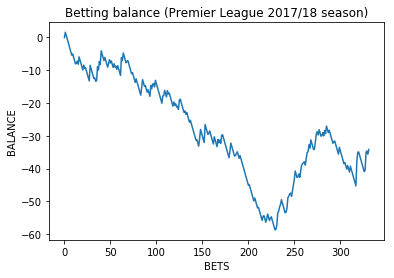

In [5]:
#BALANCE MONITORING
graph = balance_track.balance.plot.line(title = 'Betting balance (Premier League 2017/18 season)')
graph.set_xlabel('BETS')
graph.set_ylabel('BALANCE')
display(graph)

## Improvements

- The model should have additional elements, such as recent form, added to it to make it more sophisticated. Be careful not 'over fit' the model.
- Model suggestions on which bookmaker to place bet with to maximise the odds we get.
- Input team data from the previous seasons in to the model to increase the sample size we are making our predictions from. We need to find the balance of sample size. If the sample is too large, it will not represent the current team strength whereas, a sample too small may be affected by outliers.